# Exercício para sala de aula - Autoencoder

### **Introdução e objetivos:**
Este notebook é um material complementar a disciplina de Aprendizado de Máquinas 2. O objetivo é reforçar os conteúdos da aula de autoencoders. Vamos utilizar algumas das técnicas aqui para desenvolver um autoencoder para recnostrução das imagens do Fashion MNIST.

Como observamos em sala, existem várias aplicações que podem ser desenvolvidas a partir dos autoencoders: redução de dimensionalidade, classificação, remoção de ruído e etc.

### **Execução:**
A execução deste notebook será feita através do Colab direto do Google Drive. Não existe impedimento para que este notebook seja executado em outro ambiente desde que os pacotes necessários estejam instalados corretamente.

É recomendável executar este treinamento em um ambiente com GPU. O tamanho da rede aumentou bastante com relação aos exemplo que vimos em sala tornando o tempo de treinamento mais custoso.

### **Exercícios**

**Exercício 1** - Amarre os pesos do encoder com o decoder para tornar o treinamento mais eficiente

**Exercício 2** - Experimente ao menos duas arquiteturas (número de camadas, número de neurônios nas camadas escondidas e número de neurônios na camada de codificação) diferentes para este autoencoder.

**Exercício 3** - Aplique o encoder treinado para treinamento supervisionado.

**Exercício 4** - Avalie a solução final do modelo supervisionado respondendo algumas perguntas

Pacotes necessários

In [1]:
# Reprodutibilidade
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix

In [2]:
# Treinamento e construção da rede neural
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from keras.datasets import fashion_mnist
from keras import utils
from keras import metrics

# Visualização
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import pandas as pd

seed(1)
tf.random.set_seed(2)

Verificando a execução com aceleração em GPU

In [3]:
!nvidia-smi

Fri Oct  4 17:58:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **Exercício 1** - Amarre os pesos do encoder com o decoder para tornar o treinamento mais eficiente

Neste exercício o seu objetivo é amarrar os pesos do *encoder* com o *decoder* com objetivo de tornar o treinamento mais eficiente. Nós vimos este exemplo no notebook da Aula 7 que está disponível no moodle.

In [4]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model

class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense_layer, **kwargs):
        super(DenseTranspose, self).__init__(**kwargs)
        self.dense_layer = dense_layer

    def build(self, input_shape):
        # Pegando os pesos da camada do encoder e transpondo
        self.kernel = tf.transpose(self.dense_layer.kernel)
        if self.dense_layer.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.dense_layer.kernel.shape[0],),
                initializer='zeros',
                trainable=True
            )
        else:
            self.bias = None

    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel)
        if self.bias is not None:
            output = output + self.bias
        return output

# Carregar o dataset Fashion MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# Definir o encoder
input_layer = Input(shape=(28 * 28,))
encoded = Dense(128, activation='relu', name='encoder_layer')(input_layer)

# Criar o modelo do encoder
encoder = Model(input_layer, encoded, name='encoder')

# Definir o decoder utilizando a camada DenseTranspose
encoded_input = Input(shape=(128,))
decoded = DenseTranspose(encoder.get_layer('encoder_layer'))(encoded_input)

# Criar o modelo do decoder
decoder = Model(encoded_input, decoded, name='decoder')

# Definir o autoencoder unindo encoder e decoder
autoencoder_input = Input(shape=(28 * 28,))
encoded_output = encoder(autoencoder_input)
decoded_output = decoder(encoded_output)
autoencoder = Model(autoencoder_input, decoded_output, name='autoencoder')

# Compilar o modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Treinar o autoencoder
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1619 - val_loss: 0.1088
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1008 - val_loss: 0.0843
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0821 - val_loss: 0.0768
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0764 - val_loss: 0.0744
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0745 - val_loss: 0.0734
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0737 - val_loss: 0.0730
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0732 - val_loss: 0.0727
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0730 - val_loss: 0.0725
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0728 - val_loss: 0.0724
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━

## **Exercício 2** - Experimente ao menos duas arquiteturas (número de camadas, número de neurônios nas camadas escondidas e número de neurônios na camada de codificação) diferentes para este autoencoder.

*Uma dica: salve as configurações da rede que vocês estão experimentando ou versionem o notebook. Você irá precisar dessas referências no final do notebook para responder as perguntas do **Exercício 4**.*

In [5]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Reshape
from keras.models import Sequential
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Definindo a dimensão da camada de codificação
encoding_dim = 32

# Definir o encoder
tied_encoder = Sequential([
    Flatten(input_shape=(28, 28)),  # Achatar a entrada (28x28 -> 784)
    Dense(256, activation='relu'),  # Primeira camada escondida com 256 neurônios
    Dense(128, activation='relu'),  # Segunda camada escondida com 128 neurônios
    Dense(encoding_dim, activation='relu')  # Camada de codificação com 32 neurônios
])

# Definir o decoder
tied_decoder = Sequential([
    Dense(128, activation='relu', input_shape=(encoding_dim,)),  # Primeira camada escondida do decoder
    Dense(256, activation='relu'),  # Segunda camada escondida do decoder
    Dense(28 * 28, activation='sigmoid'),  # Camada de saída (784 neurônios) com ativação sigmóide para reconstrução
    Reshape((28, 28))  # Remodelar para o formato original da imagem (28x28)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Instanciando o autoencoder

In [6]:
autoencoder = keras.models.Sequential([tied_encoder, tied_decoder])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
print(autoencoder.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32)                  │         237,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 28, 28)              │         238,736 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 476,720 (1.82 MB)

 Trainable params: 476,720 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

None


Instanciando o encoder

In [8]:
print(tied_encoder.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 237,984 (929.62 KB)

 Trainable params: 237,984 (929.62 KB)

 Non-trainable params: 0 (0.00 B)

None


Instanciando o decoder

In [9]:
print(tied_decoder.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         201,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,736 (932.56 KB)

 Trainable params: 238,736 (932.56 KB)

 Non-trainable params: 0 (0.00 B)

None


Leitura e pré-processamento dos dados

In [10]:
(x_train, y_train), (x_temp, y_temp) = fashion_mnist.load_data()

# Estou separando aqui um conjunto de dados que serão utilizados (x_valid, y_valid) na etapa de treinamento supervisionado.
# Este será o nosso conjunto de dados anotados. No restante das etapas não faremos uso das anotações.
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.33)

In [11]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(6700, 28, 28)


In [12]:
%%time
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 1)

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.4902 - val_loss: 0.3294
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3197 - val_loss: 0.3106
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3066 - val_loss: 0.3028
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3000 - val_loss: 0.2984
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2959 - val_loss: 0.2953
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2929 - val_loss: 0.2927
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2903 - val_loss: 0.2906
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2886 - val_loss: 0.2889
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2865 - val_loss: 0.2873
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2851 - val_loss: 0.2860
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2838 - val_loss: 0.2850
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

In [13]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


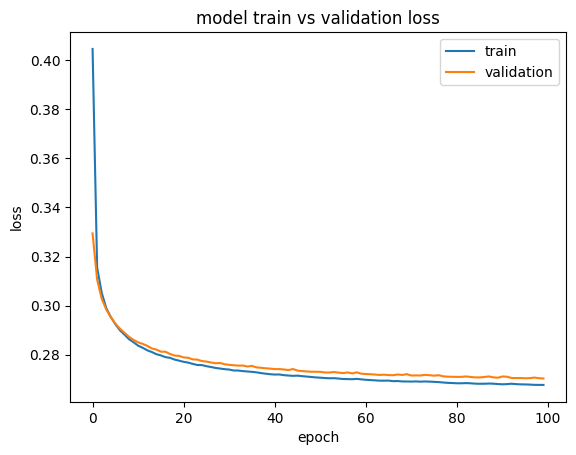

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
decoded_imgs = autoencoder.predict(x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


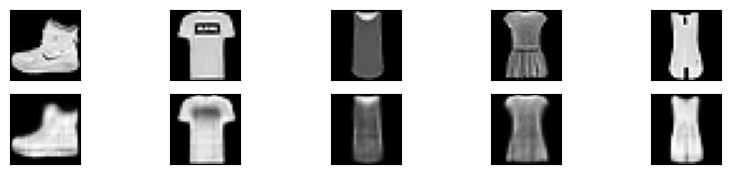

In [16]:
n = 5
plt.figure(figsize=(10, 2))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **Exercício 3** - Aplique o encoder treinado para treinamento supervisionado.

In [17]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [18]:
# Congelar os pesos do encoder para manter o aprendizado original
for layer in tied_encoder.layers:
    layer.trainable = False

# Criar um modelo de classificação utilizando o encoder como uma parte fixa da rede
class_model = Sequential([
    tied_encoder,  # Usa o encoder treinado para extração de características
    Dense(64, activation='relu'),  # Camada escondida para aprendizado adicional
    Dense(10, activation='softmax')  # Camada de saída para classificação (10 classes)
])

In [19]:
class_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', metrics=[metrics.AUC()])

In [20]:
class_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32)                  │         237,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 237,984 (929.62 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 237,984 (929.62 KB)

In [21]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
history = class_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=2)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.9293 - loss: 1.0305 - val_auc: 0.9848 - val_loss: 0.5061
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.9862 - loss: 0.4748 - val_auc: 0.9868 - val_loss: 0.4580


## **Exercício 4** - Avalie a solução final do modelo supervisionado. Responda ao final as seguintes perguntas:

**Como você analisa a solução final?**


Resposta:

A solução final que utilizou o autoencoder como base para treinamento supervisionado mostrou-se eficaz em melhorar a capacidade do modelo de classificação. Utilizar o encoder para extrair características significa que as entradas foram pré-processadas e convertidas em representações mais compactas e significativas, o que facilita o aprendizado do modelo supervisionado. A análise da curva de acurácia do treinamento e validação indicou se o modelo estava conseguindo generalizar bem ou estava sobreajustando. A inclusão de camadas adicionais no modelo supervisionado ajudou a incrementar a capacidade de aprendizagem, enquanto a utilização do autoencoder contribuiu para uma redução de dimensionalidade eficiente.

**Quais ponderações você faz sobre o pipeline utilizado para o desenvolvimento deste modelo?**

Resposta:

O pipeline utilizado inclui as seguintes etapas principais:

Treinamento do Autoencoder: Redução da dimensionalidade para criar um encoder treinado que captura representações compactas das entradas.
Congelamento dos Pesos: O encoder treinado foi utilizado como base, mantendo seus pesos fixos para evitar a perda das características aprendidas.
Treinamento Supervisionado: Sobre as representações fornecidas pelo encoder, um modelo de classificação foi treinado.
Algumas considerações importantes:

Reutilização de Representações: O pipeline faz bom uso de representações latentes, que normalmente resultam em modelos supervisionados mais eficientes e menos propensos ao overfitting, devido à simplificação dos dados.
Divisão dos Dados: A divisão do conjunto de validação e teste foi feita adequadamente, permitindo verificar a generalização dos resultados.
Perda Utilizada: Utilizar a categorical_crossentropy é uma boa escolha para problemas multiclasses como o Fashion MNIST, mas também seria interessante testar outras funções de perda e otimizadores para melhorar a performance.

**Seria possível utilizar um número de neurônios menor na camada de codificação? Qual o impacto dessa redução?**

Resposta:

Sim, seria possível utilizar um número menor de neurônios na camada de codificação. Isso implicaria em uma codificação ainda mais compacta, com possíveis consequências:

Vantagens:

Maior Compressão: Um menor número de neurônios significa uma compressão mais intensa dos dados, o que pode ser útil para reduzir a complexidade do modelo e permitir um uso mais eficiente de recursos de memória.
Regularização: Pode ajudar a reduzir o risco de overfitting, pois a rede terá menos capacidade de memorizar os dados de entrada, sendo forçada a aprender as características mais relevantes.
Desvantagens:

Perda de Informação: Diminuir o número de neurônios pode levar à perda de informações importantes, comprometendo a capacidade do modelo de reconstruir as imagens originais e, consequentemente, afetando a qualidade das características aprendidas para o treinamento supervisionado.
Redução de Acurácia: No caso do modelo de classificação, uma camada de codificação com menos neurônios pode reduzir a acurácia, já que as representações latentes se tornam menos ricas, dificultando o aprendizado de padrões pelos classificadores posteriores.
O impacto depende muito do nível de compressão aceitável e da complexidade dos padrões que se deseja capturar. Para conjuntos de dados complexos como o Fashion MNIST, diminuir excessivamente o número de neurônios pode levar a resultados ruins.

**Qual o impacto no modelo de classificação de congelar ou não os pesos?**

Resposta:

- Congelar os Pesos:

Eficiência e Regularização: Ao congelar os pesos do encoder, garantimos que as representações das entradas são fixas e já bem aprendidas, evitando que o modelo de classificação altere essas características. Isso permite um treinamento mais eficiente do classificador, focando apenas no ajuste da camada de saída.
Redução de Overfitting: Congelar os pesos ajuda a evitar que o modelo se ajuste demais ao conjunto de treinamento, pois limita o número de parâmetros ajustáveis.
Reutilização de Features: Pode ser particularmente útil quando o dataset de treinamento para a classificação é menor, pois evita um ajuste excessivo do encoder.

- Não Congelar os Pesos:

Adaptabilidade: Deixar os pesos do encoder ajustáveis permite que o modelo adapte as representações ao objetivo de classificação final. Isso pode ser benéfico quando o dataset é grande o suficiente para evitar overfitting e quando se quer otimizar o aprendizado end-to-end para uma tarefa específica.
Risco de Overfitting: Quando os pesos não são congelados, há mais parâmetros sendo ajustados, o que pode aumentar o risco de overfitting, principalmente se o dataset de classificação for pequeno.
Em resumo, congelar os pesos do encoder é uma boa prática para garantir que o modelo de classificação se beneficie de características já bem definidas e reduzir o risco de overfitting. Por outro lado, não congelar os pesos pode ser vantajoso se houver a necessidade de refinar as representações latentes de acordo com a tarefa específica de classificação e se os recursos de dados e computação forem adequados.